# Transformer timeseries model
https://www.linkedin.com/pulse/how-i-turned-nlp-transformer-time-series-predictor-zimbres-phd/

This is 1h verion

In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data

In [2]:
stock = 'RENT3.SA'
source = 'yahoo'

start = datetime.datetime(2005, 8, 19)
end = datetime.datetime(2021, 1, 9)

goog_df = data.DataReader(stock, source, start, end)
goog_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2005-08-19,1.500197,1.428211,1.487720,1.486760,30090030.0,1.033763
2005-08-22,1.511715,1.487720,1.511715,1.505956,3272490.0,1.047111
2005-08-23,1.497318,1.479081,1.497318,1.497318,2503595.0,1.041104
2005-08-24,1.497318,1.488680,1.497318,1.492519,50700154.0,1.037768
2005-08-25,1.532831,1.505956,1.532831,1.530912,13802594.0,1.064463
...,...,...,...,...,...,...
2021-01-04,69.639999,66.820000,69.639999,67.779999,3797800.0,67.265732
2021-01-05,68.160004,66.150002,67.849998,67.379997,3696600.0,66.868774
2021-01-06,67.599998,63.250000,67.330002,63.500000,8018200.0,63.018211


In [3]:
df = pd.read_csv('imbalance_state_mwh2022-01-01--2022-03-18.csv')

In [5]:
def change_timeseries_aggregation_step(timeseries: pd.DataFrame, aggregation_step: int):
    '''
    Take univariate timeseries with 1min data and aggregate.
    :param timeseries:
    :param aggregation_step:
    :return:
    '''
    n_count = timeseries.shape[0]
    n_count_aggregated = round(n_count / aggregation_step)
    new_entries = {'from': [], 'aggregate': []}
    for i in range(0, n_count, aggregation_step):
        chunk = timeseries.iloc[i:(i + aggregation_step), :]
        aggregate = (chunk.iloc[:, 0].mean())

        new_entry_timestamp = chunk.index[0]

        new_entries['from'].append(new_entry_timestamp)
        new_entries['aggregate'].append(aggregate)
    aggregated_df = pd.DataFrame(data=new_entries)
    return aggregated_df

In [6]:
df = pd.read_csv('imbalance_state_mwh2022-01-01--2022-03-18.csv', index_col=1,parse_dates=True)
df.drop(['Unnamed: 0', 'to'], inplace=True, axis=1)

aggregated_df = change_timeseries_aggregation_step(df.iloc[:, 0:1], 60)
aggregated_df['from'] = pd.to_datetime(aggregated_df['from'])
dataset = aggregated_df

In [7]:
dataset=dataset['aggregate']

In [8]:
dataset

0       102.641250
1        -9.939300
2       -11.132117
3       -27.488017
4       -12.025350
           ...    
1843      3.525583
1844    -50.961300
1845    -74.211917
1846    -84.481983
1847    -23.344949
Name: aggregate, Length: 1848, dtype: float64

In [9]:
goog_df['Adj Close'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3824 entries, 2005-08-19 to 2021-01-08
Series name: Adj Close
Non-Null Count  Dtype  
--------------  -----  
3824 non-null   float64
dtypes: float64(1)
memory usage: 59.8 KB


In [10]:
goog_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2005-08-19,1.500197,1.428211,1.487720,1.486760,30090030.0,1.033763
2005-08-22,1.511715,1.487720,1.511715,1.505956,3272490.0,1.047111
2005-08-23,1.497318,1.479081,1.497318,1.497318,2503595.0,1.041104
2005-08-24,1.497318,1.488680,1.497318,1.492519,50700154.0,1.037768
2005-08-25,1.532831,1.505956,1.532831,1.530912,13802594.0,1.064463
...,...,...,...,...,...,...
2021-01-04,69.639999,66.820000,69.639999,67.779999,3797800.0,67.265732
2021-01-05,68.160004,66.150002,67.849998,67.379997,3696600.0,66.868774
2021-01-06,67.599998,63.250000,67.330002,63.500000,8018200.0,63.018211


In [13]:
# dataset = goog_df['Adj Close']

import tensorflow as tf
import pandas as pd  
import numpy as np
from  sklearn.preprocessing import MinMaxScaler

dataset = np.array(dataset.astype('float32')).reshape(-1,1)

def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

dataset=norm(dataset)

look_back=8
np.random.seed(7)
train_size = int(len(dataset) * 0.99)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

def create_dataset(dataset, look_back=look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


X0=trainX[0:-2]
Y0=trainX[1:-1]

X0=X0.reshape(X0.shape[0],X0.shape[1],1).astype(np.float32)
Y0=Y0.reshape(Y0.shape[0],Y0.shape[1],1).astype(np.float32)
X0.shape

1829 19


(1819, 8, 1)

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")


In [15]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [16]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, 8)

    def forward(self, x):
        return F.relu(self.proj(x))
        
        
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [17]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [18]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    

In [19]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


In [20]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)


In [21]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


In [22]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('float32')
    return torch.from_numpy(subsequent_mask) == 0


def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [23]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [24]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [25]:
class Embeddings1(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings1, self).__init__()
        self.d_model = d_model
 
    def forward(self, x):
        return torch.cat(4*[x]).reshape(-1,8,self.d_model)  * math.sqrt(self.d_model)

In [26]:
class Embeddings2(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings2, self).__init__()
        self.d_model = d_model
 
    def forward(self, x):
        return torch.cat(4*[x]).reshape(-1,7,self.d_model)  * math.sqrt(self.d_model)

In [27]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x


In [28]:
def make_model(src_vocab, tgt_vocab, N=2, 
               d_model=4, d_ff=32, h=4, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings1(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings2(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model


In [29]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [30]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss #/ total_tokens

In [31]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)


In [32]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        for p in self.optimizer.param_groups:
            p['lr'] = learning
        self._rate = learning
        self.optimizer.step()
        
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9))


In [33]:
# This was incorrect at first!
CONST_SHAPE = X0.shape[0]

In [34]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data1 = torch.from_numpy(X0.reshape(CONST_SHAPE,8))#.long()
        data1[:, 0] = 1
        data2 = torch.from_numpy(Y0.reshape(CONST_SHAPE,8))#.long()
        data2[:, 0] = 1
        src = Variable(data1, requires_grad=False)
        tgt = Variable(data2, requires_grad=False)
        yield Batch(src, tgt, 0)


In [75]:

class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion 
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        x=torch.sum(x.reshape(CONST_SHAPE,7,-1), (2))
        loss = self.criterion(torch.sum(x,(0)), 
                              torch.sum(y,(0))) #/ norm
        learning=0.001
        if loss<0.01:
            learning=learning/3

        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data #* norm

## Training the model

In [76]:
V = 200
criterion = nn.MSELoss()
learning=0.001
model = make_model(V, V, N=2)

model_opt = NoamOpt(model.src_embed[0].d_model, 10, 400,
        torch.optim.Adam(model.parameters(), lr=learning, betas=(0.9, 0.98), eps=1e-9))


for epoch in range(300):
    #model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))


/tmp/ipykernel_44100/620269327.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


Epoch Step: 1 Loss: 2460.181396 Tokens per Sec: 159740.687500
Epoch Step: 1 Loss: 956.883301 Tokens per Sec: 170323.125000
Epoch Step: 1 Loss: 339.948364 Tokens per Sec: 169841.328125
Epoch Step: 1 Loss: 96.632645 Tokens per Sec: 173476.750000
Epoch Step: 1 Loss: 14.537835 Tokens per Sec: 169420.031250
Epoch Step: 1 Loss: 3.403139 Tokens per Sec: 169197.968750
Epoch Step: 1 Loss: 0.998672 Tokens per Sec: 171448.484375
Epoch Step: 1 Loss: 0.607514 Tokens per Sec: 171474.093750
Epoch Step: 1 Loss: 0.236051 Tokens per Sec: 156910.031250
Epoch Step: 1 Loss: 0.313800 Tokens per Sec: 153749.390625
Epoch Step: 1 Loss: 0.231279 Tokens per Sec: 165266.796875
Epoch Step: 1 Loss: 0.275141 Tokens per Sec: 168589.281250
Epoch Step: 1 Loss: 0.253993 Tokens per Sec: 168486.296875
Epoch Step: 1 Loss: 0.194730 Tokens per Sec: 168383.453125
Epoch Step: 1 Loss: 0.162301 Tokens per Sec: 166678.515625
Epoch Step: 1 Loss: 0.143426 Tokens per Sec: 158602.250000
Epoch Step: 1 Loss: 0.134465 Tokens per Sec: 15

Epoch Step: 1 Loss: 0.003310 Tokens per Sec: 165332.312500
Epoch Step: 1 Loss: 0.000843 Tokens per Sec: 164424.234375
Epoch Step: 1 Loss: 0.000705 Tokens per Sec: 170267.984375
Epoch Step: 1 Loss: 0.000564 Tokens per Sec: 166946.734375
Epoch Step: 1 Loss: 0.000565 Tokens per Sec: 162032.890625
Epoch Step: 1 Loss: 0.000739 Tokens per Sec: 164901.734375
Epoch Step: 1 Loss: 0.000567 Tokens per Sec: 163030.359375
Epoch Step: 1 Loss: 0.001552 Tokens per Sec: 157970.437500
Epoch Step: 1 Loss: 0.003424 Tokens per Sec: 165931.093750
Epoch Step: 1 Loss: 0.001749 Tokens per Sec: 166648.859375
Epoch Step: 1 Loss: 0.001270 Tokens per Sec: 165331.046875
Epoch Step: 1 Loss: 0.000534 Tokens per Sec: 164096.437500
Epoch Step: 1 Loss: 0.000753 Tokens per Sec: 166436.843750
Epoch Step: 1 Loss: 0.000878 Tokens per Sec: 170650.125000
Epoch Step: 1 Loss: 0.000742 Tokens per Sec: 169848.890625
Epoch Step: 1 Loss: 0.000275 Tokens per Sec: 166542.781250
Epoch Step: 1 Loss: 0.000662 Tokens per Sec: 162329.7812

Epoch Step: 1 Loss: 0.000006 Tokens per Sec: 154440.703125
Epoch Step: 1 Loss: 0.000001 Tokens per Sec: 148695.109375
Epoch Step: 1 Loss: 0.000149 Tokens per Sec: 150109.781250
Epoch Step: 1 Loss: 0.000016 Tokens per Sec: 148721.000000
Epoch Step: 1 Loss: 0.000007 Tokens per Sec: 149076.968750
Epoch Step: 1 Loss: 0.000000 Tokens per Sec: 128998.742188
Epoch Step: 1 Loss: 0.000012 Tokens per Sec: 136675.875000
Epoch Step: 1 Loss: 0.000032 Tokens per Sec: 126032.937500
Epoch Step: 1 Loss: 0.000011 Tokens per Sec: 151326.062500
Epoch Step: 1 Loss: 0.000020 Tokens per Sec: 150370.703125
Epoch Step: 1 Loss: 0.000000 Tokens per Sec: 146809.921875
Epoch Step: 1 Loss: 0.000061 Tokens per Sec: 150440.421875
Epoch Step: 1 Loss: 0.000002 Tokens per Sec: 142422.593750
Epoch Step: 1 Loss: 0.000026 Tokens per Sec: 137541.734375
Epoch Step: 1 Loss: 0.000009 Tokens per Sec: 150747.390625
Epoch Step: 1 Loss: 0.000022 Tokens per Sec: 149265.828125
Epoch Step: 1 Loss: 0.000023 Tokens per Sec: 150423.0312

## Making predictions

In [77]:
PATH = './pytorch_time_series_model_loss_1h.pth'


X0=trainX[0:-2]
Y0=trainX[1:-1]

X0=X0.reshape(X0.shape[0],X0.shape[1],1).astype(np.float32)
Y0=Y0.reshape(Y0.shape[0],Y0.shape[1],1).astype(np.float32)


In [78]:
X0.shape

(1819, 8, 1)

In [79]:

# place=21944

# X0=X0[place]
# Y0=[Y0[place][0:7].reshape(1,-1)]

In [80]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 7).fill_(start_symbol).type_as(src.data)
    for i in range(8-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = torch.sum(src*torch.sum(model.generator(out),(1)))
    return prob

In [81]:
place=1600

actuals= []
errors = []
predictions = []

for i in range(place, place+200):
    new_X0=X0[i]
    new_Y0=[Y0[i][0:7].reshape(1,-1)]

    model.load_state_dict(torch.load(PATH))

    src = Variable(torch.Tensor(new_X0.reshape(1,-1)) )
    src_mask = Variable(torch.ones(1,1,8))



    pred=greedy_decode(model, src, src_mask, max_len=8, start_symbol=1)

    print("actual:", new_Y0[0][0][-1],"prediction:",pred.detach().numpy())
    print('error',abs(new_Y0[0][0][-1] -pred.detach().numpy()))
    actuals.append(new_Y0[0][0][-1])
    errors.append(abs(new_Y0[0][0][-1] -pred.detach().numpy()))
    predictions.append(pred.detach().numpy())

actual: 0.41532084 prediction: 0.35714644
error 0.0581744
actual: 0.5457741 prediction: 0.42860496
error 0.11716914
actual: 0.54424435 prediction: 0.44896126
error 0.09528309
actual: 0.5539413 prediction: 0.41265842
error 0.14128289
actual: 0.48061305 prediction: 0.5255702
error 0.04495716
actual: 0.45384413 prediction: 0.42738608
error 0.026458055
actual: 0.4260552 prediction: 0.52158344
error 0.095528245
actual: 0.40459684 prediction: 0.55676544
error 0.1521686
actual: 0.40130112 prediction: 0.5600235
error 0.15872237
actual: 0.52026844 prediction: 0.54440534
error 0.0241369
actual: 0.33460286 prediction: 0.49982527
error 0.1652224
actual: 0.29511234 prediction: 0.42538154
error 0.1302692
actual: 0.33907604 prediction: 0.46841392
error 0.12933788
actual: 0.49227786 prediction: 0.4068876
error 0.08539027
actual: 0.5725315 prediction: 0.5064743
error 0.066057205
actual: 0.5632574 prediction: 0.3515001
error 0.2117573
actual: 0.5405098 prediction: 0.3354993
error 0.20501053
actual: 0.51

actual: 0.56148773 prediction: 0.68150187
error 0.12001413
actual: 0.49426022 prediction: 0.64296055
error 0.14870033
actual: 0.5198135 prediction: 0.71327746
error 0.19346398
actual: 0.42294884 prediction: 0.5630625
error 0.14011365
actual: 0.5206166 prediction: 0.5793144
error 0.05869782
actual: 0.5108591 prediction: 0.5726954
error 0.061836302
actual: 0.50945497 prediction: 0.5661245
error 0.056669533
actual: 0.51033574 prediction: 0.5688118
error 0.05847603
actual: 0.49250317 prediction: 0.49753472
error 0.005031556
actual: 0.45632863 prediction: 0.5507636
error 0.09443498
actual: 0.36278805 prediction: 0.5536242
error 0.19083616
actual: 0.4462925 prediction: 0.55612165
error 0.10982916
actual: 0.5858447 prediction: 0.5250789
error 0.060765803
actual: 0.5387253 prediction: 0.5339715
error 0.004753828
actual: 0.5933526 prediction: 0.4722342
error 0.12111843
actual: 0.5156388 prediction: 0.39126182
error 0.12437701
actual: 0.5234924 prediction: 0.51142526
error 0.012067139
actual: 0.

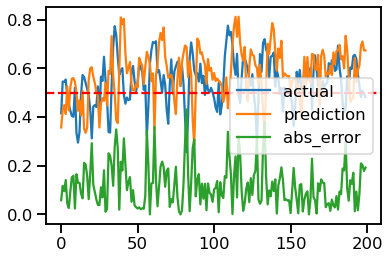

In [82]:
plt.plot(actuals, label='actual')
plt.plot(predictions, label='prediction')
plt.plot(errors, label='abs_error')
plt.legend()
plt.ylabel('')
plt.axhline(y=0.5, color='red', linestyle='--')

In [83]:
total=0
for i in range(len(actuals)):
    total += errors[i]/actuals[i]
print('MAPE: ', round(total.mean(),2), '%')
    

MAPE:  47.88 %


In [84]:
true_negatives = 0
false_negatives = 0

false_positives = 0
true_positives = 0
for i in range(len(actuals)):

    if predictions[i] > 0.5:
        if actuals[i] > 0.5:
            true_positives += 1
        elif actuals[i] < 0.5:
            false_positives += 1
    elif predictions[i] <= 0.5:
        if actuals[i] <= 0.5:
            true_negatives += 1
        elif actuals[i] > 0.5:
            false_negatives+=1


In [85]:
true_positives

109

In [86]:
true_negatives

9

In [87]:
false_negatives

32

In [88]:
false_positives

50

In [89]:
print('error',abs(Y0[0][0][-1] -pred.detach().numpy())/Y0[0][0][-1])

error 0.37683123


In [90]:
model.generator(out)

NameError: name 'out' is not defined

In [91]:
Y0[0][0]

array([0.4893754], dtype=float32)

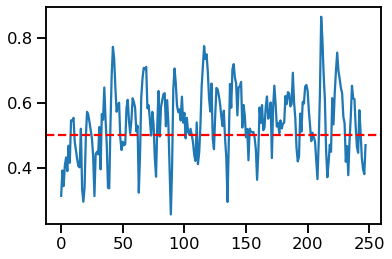

In [92]:
plt.plot(dataset[place:])
plt.axhline(y=0.5, color='red', linestyle='--')

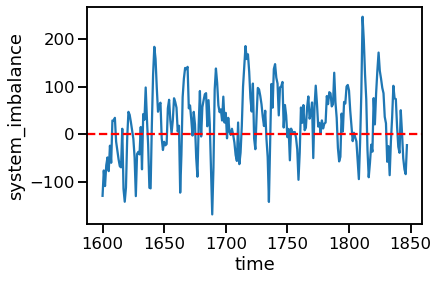

In [52]:
aggregated_df.iloc[place:,1].plot(xlabel='time', ylabel='system_imbalance')
plt.axhline(y=0, color='red', linestyle='--')

In [51]:
aggregated_df.iloc[place:].head(50)

,from,aggregate
1600,2022-03-08 14:00:00+00:00,-130.196767
1601,2022-03-08 15:00:00+00:00,-76.734950
1602,2022-03-08 16:00:00+00:00,-109.593200
1603,2022-03-08 17:00:00+00:00,-65.755167
1604,2022-03-08 18:00:00+00:00,-49.287783
1605,2022-03-08 19:00:00+00:00,-78.145367
1606,2022-03-08 20:00:00+00:00,-24.523667
1607,2022-03-08 21:00:00+00:00,-60.514517
1608,2022-03-08 22:00:00+00:00,28.577933
1609,2022-03-08 23:00:00+00:00,27.533167
